In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import make_interpolation, ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, convert_mask_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct

import torchvision.models as models
from torch.autograd import Variable


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))


In [2]:
# https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb

import saliency.core as saliency

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

transformer = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

def LoadNumpy(file_path):
    im = Image.open(file_path)
    im = im.resize((224, 224)) # reserve channel 
    im = np.asarray(im)
    return im    

# def PreprocessImages(images):
#     # assumes input is 4-D, with range [0,255]
#     #
#     # torchvision have color channel as first dimension
#     # with normalization relative to mean/std of ImageNet:
#     #    https://pytorch.org/vision/stable/models.html
#     images = np.array(images)
#     images = images/255
#     images = np.transpose(images, (0,3,1,2))
#     images = torch.tensor(images, dtype=torch.float32)
#     images = transformer.forward(images)
#     return images.requires_grad_(True)

def LoadTensor(file_path):
    im = Image.open(file_path)
    temp = np.asarray(im)
#     if len(temp.shape) == 3: images = transformer(im)    
#     else: return None
    
    images = transformer(im)    
    return images.requires_grad_(True)

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [3]:
# data_path="/root/data/ILSVRC2012_val/"

# _, valid_datasets = get_datasets("imagenet1k", data_path)
# valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=1, shuffle=False, num_workers=2)

# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# eval_mode = model.eval()

In [4]:
# # n02443484: 40 black-footed_ferret
# # n01614925: 398 bald_eagle

# data_path="/root/data/ILSVRC2012_val/"

# ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
# ferrot_idx = os.listdir(ferrot_dir)[1]
# ferrot_np = LoadNumpy(os.path.join(ferrot_dir, ferrot_idx))
# ferrot_tensor = LoadTensor(os.path.join(ferrot_dir, ferrot_idx))

# # eagle_dir = os.path.join(data_path, 'val', 'n01614925')
# # eagle_idx = os.listdir(eagle_dir)[1]
# # eagle_img = LoadNumpy(os.path.join(eagle_dir, eagle_idx))
# # eagle_tensor = LoadTensor(os.path.join(eagle_dir, eagle_idx))


In [3]:
import torchvision.transforms as T
CIFAR10_STATS = {
    'mean' : [0.4914, 0.4822, 0.4465],
    'std' : [0.2023, 0.1994, 0.2010]
}

transform = T.Compose([
                T.ToTensor(), 
                T.Normalize(CIFAR10_STATS['mean'], CIFAR10_STATS['std'])
            ])

valid_dataset = torchvision.datasets.CIFAR10(root='/root/data/cifar10', train=False, transform=transform)
interpolation = torch.from_numpy(np.load('/root/results/cifar10/image_simple_gradient_ascent_interpolation.npy'))

In [4]:
# interpolation.shape
model = torch.load("/root/data/cifar10/cifar10/results/densenet/script_model.pt",  map_location='cpu').eval().to('cuda:0')


/root/dh/lib/python3.8/site-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [14]:
# from ig_pkg.utils.attribution import integrated_gradient

# attribution = []
# for i in range(len(valid_dataset)):
#     label = valid_dataset[i][1]
#     interp = interpolation[i].to('cuda:0')
#     input = interp[0].to('cuda:0')
#     baseline = interp[-1].to('cuda:0')
    
#     attrib = integrated_gradient(model, input, label, baseline, interp, 'cuda:0') # tensor
    
#     attribution.append(attrib.detach().cpu())
# attribution = torch.stack(attribution)
# attribution.shape
# np.save("/root/results/cifar10/image_simple_gradient_ascent_attribution.npy", attribution.numpy())

PGD 

In [15]:
import torch
import torch.nn as nn

from ..attack import Attack


class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, eps=8/255, alpha=2/255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + \
                torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images,
                                min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

torch.Size([10000, 32, 32])

In [5]:
def logit(model, image, label):
    temp = image.unsqueeze(0).clone().detach()
    logit = model(temp)
    return logit

def score(model, image, label):
    temp = image.unsqueeze(0).clone().detach()
    logit = model(temp)
    score = torch.softmax(logit, dim = -1)
    sc = score[0, label].item()
    return sc

In [ ]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=24, device='cuda:0'):
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data

    # interp = [images]
    # st = time.time()
    sc = []
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        # print(time.time() - st)
        # print(score(model, images.squeeze(0), labels))
        sc.append(score(model, images.squeeze(0), labels))
        # interp.append(images)
    return sum(sc)/iters

for i in range(100):
    adver = pgd_attack(model, valid_dataset[i][0].unsqueeze(0), torch.tensor([valid_dataset[i][1]]), eps=0.3, alpha=2/255, iters=10, device='cuda:0')
    print(adver)

In [16]:
def pgd_attack1(model, images, device, labels, eps=0.3, alpha=2/255, iters=24):
    interp = [images]

    images = images.unsqueeze(0).to(device)
    labels = torch.tensor([labels]).to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data

    
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        
        interp.append(images.squeeze(0).clone().detach().cpu())
    print(1)
    interp = torch.stack(interp)
    return interp

In [18]:
# from ig_pkg.utils.adversarial import pgd_attack
# # print(valid_dataset[10][1])
adver = pgd_attack1(model, valid_dataset[10][0], 'cuda:0', valid_dataset[10][1], eps=0.3, alpha=2/255, iters=24)

adver.shape

1


torch.Size([25, 3, 32, 32])

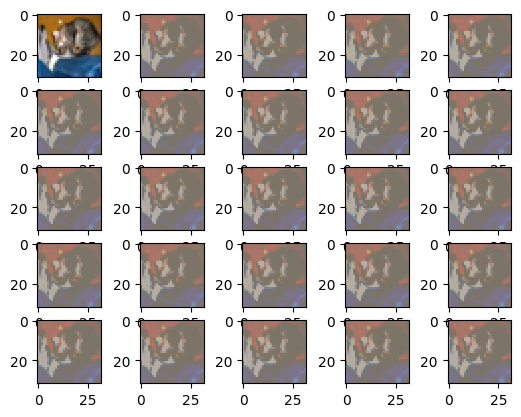

In [31]:
# adver = torch.stack(adver)
# adver.shape

fig, axes = plt.subplots(5, 5)
axes_flat = axes.flat 
# my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

for i in range(25):
    temp = adver[i]
    ax = next(axes_flat)
    ax.imshow(convert_to_img(temp.squeeze(0)))

In [23]:
import time
device = "cuda:0"
image = valid_dataset[0][0].detach().clone().to(device)
label = valid_dataset[0][1]

loss = nn.CrossEntropyLoss()
alpha = 2/225
eps = 8/225

adv_image = image.clone().detach()
adv = [adv_image]
st = time.time()
for _ in range(24):
    adv_image.requires_grad = True
    outputs = logit(model, adv_image, label)

    cost = loss(outputs, torch.tensor([label]).to(device))

    # Update adversarial images
    grad = torch.autograd.grad(cost, adv_image, retain_graph=False, create_graph=False)[0]

    adv_image = adv_image.detach() + alpha*grad.sign()
    
    delta = torch.clamp(adv_image - image, min=-eps, max=eps)
    
    adv_image = torch.clamp(image + delta, min=0, max=1).detach()
    adv.append(adv_image)
    print(score(model, adv_image.to(device), label))    
    print(time.time() - st)
    
    break

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [16]:
images = images.clone().detach().to(self.device)
labels = labels.clone().detach().to(self.device)

loss = nn.CrossEntropyLoss()
adv_images = images.clone().detach()

for _ in range(self.steps):
    adv_images.requires_grad = True
    outputs = self.get_logits(adv_images)

    # Calculate loss
    if self.targeted:
        cost = -loss(outputs, target_labels)
    else:
        cost = loss(outputs, labels)

    # Update adversarial images
    grad = torch.autograd.grad(cost, adv_images,
                                retain_graph=False, create_graph=False)[0]

    adv_images = adv_images.detach() + self.alpha*grad.sign()
    delta = torch.clamp(adv_images - images,
                        min=-self.eps, max=self.eps)
    adv_images = torch.clamp(images + delta, min=0, max=1).detach()

In [ ]:
device = 'cuda:0'
names = {
    'zero',
    'one',
    'min',
    'max',
    'scalar',
#     'encoder',
#     'optimizer',
#     'hybrid',
    'gaussian_blur',
    'gaussian',
    'uniform',
    'maximumdistance' 
}

# {'gaussian',
#  'gaussian_blur',
#  'max',
#  'maximumdistance',
#  'min',
#  'one',
#  'scalar',
#  'uniform',
#  'zero'}

index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

fig, axes = plt.subplots(2, (len(names)//2)+1, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(x))

AOPC = []
LODDs = []
Kendal = []
for name in names:
    print(name)
    a = []
    b = []
    try:
        b_generator =  get_baseline_generator(name, scalar = 0.3)
        baseline = b_generator(x=x,y=y)

    except Exception as e: 
        print("-----")
        print("fail:", name)
        print(e)
        continue
        
    attr = ig(eval_mode.to(device), x, y, baseline, device=device)
    Kendal.append(kendal_correlation(eval_mode, ferrot_tensor, baseline, attr.detach().cpu().numpy(), device))

#     print(name)
    for i in range(19):
#         k = i * 5 + 5        
        k = i + 1
        aopc, lodds = pipeline(eval_mode, ferrot_tensor.to(device), baseline, attr, k, device, name)
        
#         print(name, k, aopc, lodds)
        a.append(aopc)
        b.append(lodds)
    
    attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
    ax = next(axes_flat)
    ax.imshow(attr, **kwargs)
    ax.set_title(name)
    ax.axis("off")
    
    AOPC.append(a)
    LODDs.append(b)    
    
plt.tight_layout()